## Introduction to Logistic Regression in PyTorch


In this Notebook we will be building a Neural Network on the MNIST dataset and implementing the logistic regression model.We will be including the forward and backward pass along with the loss function and optimizers.After training the model we will evaluate how we did and visualize what we've learned.

Imports of the packages we will be using.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

### MNIST Dataset

The MNIST database (Modified National Institute of Standards and Technology database is a large database of handwritten digits that is commonly used for training various image processing systems.The MNIST database contains 60,000 training images and 10,000 testing images.

![MNIST](Figures/MnistExamples.png)

The first and foremost step in machine learning is preparing the data , this involves downloading, organzing, shuffling, processing the data so it can be fed into the model.
The torchvision package makes this easy for us by implementing many of these , allowing us to put to use these datasets in only a few lines of code.


In [5]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [6]:
print("Number of MNIST Training Examples: {}".format(len(mnist_train)))
print("Number of MNIST Testing Exmaples: {}".format(len(mnist_test)))

Number of MNIST Training Examples: 60000
Number of MNIST Testing Exmaples: 10000


As expected 60,000 of the MNIST examples are in the training set while the rest 10,000 are in the testing set. We added the transform ToTensor() to convert the input data from a PIL type into a PyTorch Tensor. Tensors are the input type that we feed into our model.

Checking a random image from our train set. The shape of ourimage tensor returns to be something 3-Dimensional , To visualize this we need to remove the 1 which indicates 


Default Image Shape torch.Size([1, 28, 28])
Reshaped Image Shape torch.Size([28, 28])
The label for this Image 0


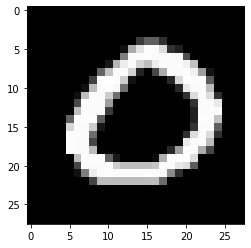

In [25]:
image , label = mnist_train[435]
print("Default Image Shape {}".format(image.shape))
image=image.reshape([28,28])
print("Reshaped Image Shape {}".format(image.shape))
plt.imshow(image, cmap="gray")
print("The label for this Image {}".format(label))

While we could directly work with the date using `torchvision.dataset` we use `Data Loader` which makes it easier for shuffling and batching.

In [21]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

An example of minibatch drawn from a data loader.

In [23]:
data_train_iter = iter(train_loader)
images , labels = data_train_iter.next()

print("Shape of the mini batch of the images: {}".format(images.shape))
print("Shape of the mini batch of the labels: {}".format(labels.shape))

Shape of the mini batch of the images: torch.Size([100, 1, 28, 28])
Shape of the mini batch of the labels: torch.Size([100])


### Logistic Regression Model

Now that we have loaded our data we will be building our Logistic Regression Model with no hidden layers.

#### The Forward Pass

While the data inputs are images i.e (2-Dimensional) we will be treating them as flat vectors. Thus to convert our inputs into row vectors we will use `view()` which is very similar to reshape in `numpy`.
Also like numpy we replace one of the dimensions to a -1 which tells PyTorch to infer this dimension based on the orignal dimensions. Below is the flattening on the minibatch we drew above in the previous section.

In [24]:
x = images.view(-1, 28*28)
print("The shape of the input: {}".format(x.shape))

The shape of the input: torch.Size([100, 784])


To get the predicted probabilities of each digit being a 0 like the image above. We start by applying a linear transformation.We multiply each pixel $x_i$ of the input row vector by a weight $w_i$ sum them all together and add a bias $b_1$. This is equivalent to a dot product between the class 0 weights and the input:

\begin{align}
y_0 = \sum_i x_i w_{i,0} + b_0
\end{align}

The magnitude of the result $y_0$ will be taken as how likley do we consider the digit to be a 0. Since our goal is to identify all the digits , so we actually get:

\begin{align}
y_0 = \sum_i x_i w_{i,0} + b_0 \\
y_1 = \sum_i x_i w_{i,1} + b_1 \\
y_2 = \sum_i x_i w_{i,2} + b_2 \\
y_3 = \sum_i x_i w_{i,3} + b_3 \\
y_4 = \sum_i x_i w_{i,4} + b_4 \\
y_5 = \sum_i x_i w_{i,5} + b_5 \\
y_6 = \sum_i x_i w_{i,6} + b_6 \\
y_7 = \sum_i x_i w_{i,7} + b_7 \\
y_8 = \sum_i x_i w_{i,8} + b_8 \\
y_9 = \sum_i x_i w_{i,9} + b_9
\end{align}

We can express this in the matrix form as: 
 \begin{align}y = x W + b\end{align}
 
 Since Parallel Computations allow us to process multiple inputs at a time we can stack $x$ inputs with a matrix $X$ giving us:
 \begin{align}y = X W + b\end{align}
 
 Visualizing the dimensions: 
 
 ![Dimension](Figures/mnist_matmul.png)
 
 
In our example the minibatch size $m$ is $100$ and the dimension of the data is $28 * 28 = 784$ and the number of classes c is 10.


The weight $W$ and bias $b$ make up the parameters of this model , when we say that we want to learn the model we refer to the fact that we need to find good values for every element in $W$ and $b$. Since we don't know what the best values are we are going to initialize $W$ randomly and set $b$ to a vector of zeros.

In [27]:
#Randomly Iniitializes Weight
W = torch.randn(784,10)/np.sqrt(784)
W.requires_grad_()

#Initializes bias b as zeros.
b = torch.zeros(10, requires_grad=True)

We set `requires_grad` = `True` for both $W$ and $b$ since this tell's PyTorch to track the gradients for these two and all the variables depenedent on them.
With these model parameters we can compute $y$.

In [28]:
#Linear Transformation for W and b
y = torch.matmul(x, W) + b

We can see what the first exmaple of our minibatch looks like , Remember bigger the number the more the model thinks the input $x$ is of that class.

In [29]:
print(y[0,:])

tensor([-0.2850,  0.0247,  0.1386, -0.3178,  0.5466, -0.1525,  0.1840, -0.2837,
         0.1090, -0.3097], grad_fn=<SliceBackward>)


We can interpret these values as probabilities if we normalize them to be positive and add upto 1 , this is achieved in logistic regression with softmax:

\begin{align}
p(y_i) = \text{softmax}(y_i) = \frac{\text{exp}(y_i)}{\sum_j\text{exp}(y_j)}
\end{align}

Since the range of the exponential function is negative and we are normalizing by the sum , the softmax function achieves our goal of producing values between 0 to 1 that sum upto 1.
PyTorch has an inbuilt softmax function  : `torch.nn.functional.softmax`

In [38]:
py = torch.nn.functional.softmax(y, dim=1)
print("py[0]: {}".format(py[0]))

py[0]: tensor([0.0749, 0.1021, 0.1144, 0.0725, 0.1720, 0.0855, 0.1197, 0.0750, 0.1110,
        0.0730], grad_fn=<SelectBackward>)


#### The Cross-Entropy Loss

All we've done till now is randomly initialized the values of $W$ and $b$.Before we adjust any of the weights we need to see how the model is doing.We do this with a loss function to see how badly is the model performing.The loss function takes the model's prediction and returns a single number i.e a scalar summarizing the model performance. The loss which we use here is called cross-entropy loss which basically quantifies how farm away $y'$ is from $y$.

\begin{align}
H_{y'}(y) = -\sum_i y'_i\text{log}(y_i)
\end{align}

In our case $y$ is the set of probabilities predicted by the model and $y'$ are the targeted probabilities i.e the true labels.
\
\
Cross-Entropy not only captures how correct(max probability = right answer) the model's answers are but also how confident the model was. This encourages the model to produce high probabilites for correct answers while driving down the probabilities for the wrong answers.
\
\
Our focus here is on supervised learning, thus we have the labels. Our `dataloader` automatically includes the corresponding labels for each of the inputs.

Similar to the softmax equation PyTorch has a builtin cross-entropy function: `torch.nn.functional.cross_entropy`

In [48]:
cross_entropy = torch.nn.functional.cross_entropy(y, labels)
print("Cross-Entropy:{}".format(cross_entropy))

Cross-Entropy:2.3137755393981934


Note that PyTorch's cross-entropy function combines the softmax function with cross_entropy that is why we feed in `y` instead of `py`.

#### The Backward Pass

Now that we have loss which quantifies how badly the model is doing , we can improve our model by chaning the parameters $W$ and $b$ to minimize the loss.The common way of doing this in neural networks is with Backpropagation: we take the gradient of the loss with respect wo $W$ and $b$ and take steps in the direction that reduces it.
\
First we create an optimizer , since logistic regression is pretty simple we'll use standar stochastic gradient descent(SGD) which makes the following update:

\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}

where $\theta$ is a parameter $\alpha$ is our learning rate (step-size) and $\nabla_\theta$ $matchcal{L}$ is our gradient loss with respect to $\theta$.

In [49]:
optimizer = torch.optim.SGD([W,b], lr=0.1)

When we created $W$ and $b$ we indicated that they needed gradients, to compute their gradients we use `backward()` function on the cross entropy loss.

In [50]:
cross_entropy.backward()

Each of the variables that required gradients have accumulated gradients now, we can see this in the example below.

In [64]:
b.grad

tensor([-0.0880, -0.0504,  0.0091,  0.0159,  0.1036, -0.0092,  0.0516, -0.0201,
        -0.0194,  0.0069])

We apply the gradients using our optimizer.

In [62]:
optimizer.step()

We set our learnaing rate as 0.1 , hence $b$ has been updated by `-0.1*b.grad`:

In [63]:
b

tensor([ 0.0352,  0.0202, -0.0037, -0.0064, -0.0414,  0.0037, -0.0206,  0.0080,
         0.0078, -0.0028], requires_grad=True)

We've now successfully trained the model on a minibatch i.e a 100 exmaples out of the 60,000.
/
Note: The gradients calculated by `backward()` dont override the old values instead they accumulate. Thefore you'll want to clear the gradient buffers before you compute gradients for the next minibatch.

In [66]:
print("b.grad before zero_grad():{}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad():{}".format(b.grad))

b.grad before zero_grad():tensor([-0.0880, -0.0504,  0.0091,  0.0159,  0.1036, -0.0092,  0.0516, -0.0201,
        -0.0194,  0.0069])
b.grad after zero_grad():tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


#### Model Training

To train the model we just need to repeat what we just did for the other mini batches from the training set. The steps were as follows:
1. Draw a mini batch.
2. Zero the gradients in the buffer for `W` and `b`.
3. Perform the forward pass (compute prediction, calculate loss)
4. Perfom the backward pass (compute gradients, perform SGD step)

Going through the entire dataset once is known as an epoch.
We will wrap the `train_loader` with `tqdm` which adds a handy progress bar so we can track our training process.

In [67]:
for images, labels in tqdm(train_loader):
    optimizer.zero_grad()
    
    x = images.view(-1,28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = torch.nn.functional.cross_entropy(y, labels)
    
    cross_entropy.backward()
    optimizer.step()

#### Testing

For every image in our test set, we run the data through the model and take the digit in which we have the highest confidence as our answer. We then compute an accuracy to see how how many we got correct. Since we are not interested in computing gradients during evaluation we wrap evaluation with `torch.no_grad()` , this speeds up the evaluation.

In [70]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        x = images.view(-1,28*28)
        y = torch.matmul(x, W) + b 
        
        predictions = torch.argmax(y, dim=1)
        correct +=  torch.sum((predictions == labels).float())
print("Correct Accuracy:{}".format(correct/total))


Correct Accuracy:0.90420001745224


By plotting the weights(since the model is simple) we can visualize what the model is learning as the weights transform the data directly to their logits.

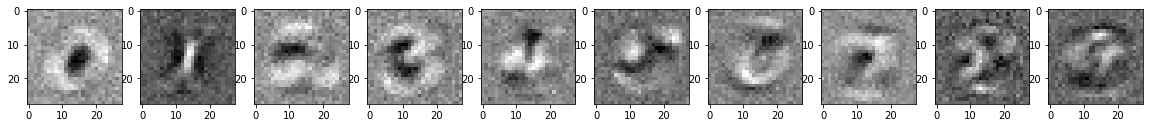

In [73]:
fig, ax = plt.subplots(1,10, figsize=(20,2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

As we can see the model learned the  template for each digit , Remember the model takes the dot product between the weights of each digit and input. Therfore the more the input matches the template for the digit, the higher the value of the dot product of that will be, which makes the model more likley to predict that digit.

#### The Full Code

In [86]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Initialize parameters
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.395)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))


Test accuracy: 0.9158999919891357
